In [1]:
from glob import iglob
from datetime import datetime
from itertools import chain, repeat

import numpy as np
import pandas as pd
from cytoolz import compose, reduce
from h5py import File
from dask import delayed, compute
from dask.bag import from_sequence
from dask.diagnostics import ProgressBar
import matplotlib.pyplot as plt

In [2]:
def is_available(filename):
    if filename.endswith("_0.h5"):
        return False
    try:
        with File(filename, 'r'):
            pass
        return True
    except Exception:
        return False


def read_scala(filename):
    with File(filename, 'r') as f:
        try:
            yield from ({'tag': tag,
                         'iom_intensity_pc': iom,
                         'img_intensity': img.sum(),
                         'delay': round(dt, 2)}
                        for tag, iom, img, dt
                        in zip(f['/bunches'],
                               f['/photon_diagnostics/FEL01'
                                 '/I0_monitor/iom_sh_a_pc'],
                               f['/vmi/andor'],
                               f['/user_laser/delay_line/position']))
        except KeyError:
            return


def read_img(filename):
    with File(filename, 'r') as f:
        try:
            yield from ({'tag': tag,
                         'img': img.astype('double')}
                        for tag, img
                        in zip(f['/bunches'],
                               f['/vmi/andor']))
        except KeyError:
            return

In [3]:
run = 9
filenames = sorted(fn for fn in set(iglob(f"/data/Test/Run_{run:03d}/rawdata/*.h5")) if is_available(fn))
writein = f"/data/Test/Run_{run:03d}/work"

with ProgressBar():
    df = (
        from_sequence(filenames)
        .map(read_scala)
        .flatten()
        .to_dataframe()
        .compute()
    ).set_index("tag")
df

[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  6min  6.2s


,delay,img_intensity,iom_intensity_pc
tag,,,
475921923,-5.60,86063920,199.201012
475921924,-5.60,88295382,197.068977
475921925,-5.60,89760347,227.509689
475921926,-5.60,85357714,177.508163
475921927,-5.60,88709054,199.877357
475921928,-5.60,88281449,193.647766
475921929,-5.60,86398174,205.423737
475921930,-5.60,87019286,180.865860
475921931,-5.60,88837803,211.569214


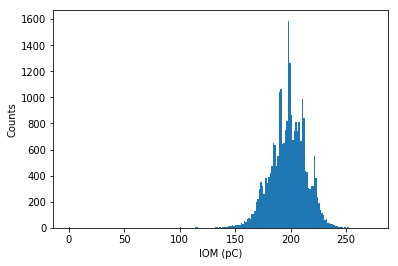

In [5]:
plt.hist(df["iom_intensity_pc"], bins=200)
plt.xlabel("IOM (pC)")
plt.ylabel("Counts")
plt.show()

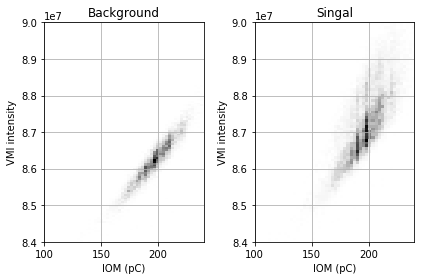

In [6]:
bg_period, bg_mod = 3, 0  # /Background_Period
df["is_bg"] = df.index % bg_period == bg_mod
plt.figure()
plt.subplot(121)
where = df["is_bg"]
plt.hist2d(df[where]["iom_intensity_pc"],
           df[where]["img_intensity"], bins=[100, 100], cmap="Greys")
plt.title("Background")
plt.xlabel("IOM (pC)")
plt.ylabel("VMI intensity")
plt.xlim(100, 240)
plt.ylim(8.4e7, 9e7)
plt.grid(True)

plt.subplot(122)
where = ~df["is_bg"]
plt.hist2d(df[where]["iom_intensity_pc"],
           df[where]["img_intensity"], bins=[100, 100], cmap="Greys")
plt.title("Singal")
plt.xlabel("IOM (pC)")
plt.ylabel("VMI intensity")
plt.xlim(100, 240)
plt.ylim(8.4e7, 9e7)
plt.grid(True)
plt.tight_layout()
plt.show()

In [7]:
ddf = (
    from_sequence(filenames)
    .map(read_img)
    .flatten()
    .to_dataframe()
    .merge(df, on="tag")
)
ddf

,img,tag,delay,img_intensity,iom_intensity_pc,is_bg
npartitions=130,,,,,,
,object,int64,float64,int64,float64,bool
,...,...,...,...,...,...
...,...,...,...,...,...,...
,...,...,...,...,...,...
,...,...,...,...,...,...


In [9]:
where = (
    150 < ddf['iom_intensity_pc']
)

with ProgressBar():
    summed = compute(
        *[
            {
                'is_bg': bg, 'delay': dt,
                'count': delayed(ddf[where & (ddf['is_bg'] == bg) & (ddf['delay'] == dt)]['img'].to_bag().count()),
                'summed': delayed(ddf[where & (ddf['is_bg'] == bg) & (ddf['delay'] == dt)]['img'].to_bag().sum()),
            }
            for bg in [True, False] for dt in df["delay"].unique()
        ],
    )

summed = pd.DataFrame(list(summed)).set_index(['delay', 'is_bg'])
summed

[########################################] | 100% Completed |  5min 48.7s


,,count,summed
delay,is_bg,,
-5.60,True,667,"[[67779.0, 66298.0, 67428.0, 67543.0, 67828.0,..."
-5.58,True,667,"[[67826.0, 66073.0, 67456.0, 67460.0, 67785.0,..."
-5.56,True,663,"[[67425.0, 66077.0, 66984.0, 67208.0, 67418.0,..."
-5.55,True,6,"[[614.0, 599.0, 603.0, 602.0, 603.0, 595.0, 61..."
-5.54,True,661,"[[67227.0, 65979.0, 66759.0, 66925.0, 67142.0,..."
-5.52,True,666,"[[67691.0, 66166.0, 67271.0, 67447.0, 67607.0,..."
-5.50,True,660,"[[67129.0, 65601.0, 66663.0, 66847.0, 66979.0,..."
-5.48,True,661,"[[67249.0, 65828.0, 66741.0, 66927.0, 67098.0,..."
0.00,True,0,0


/app/.venv/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in long_scalars
  if __name__ == '__main__':


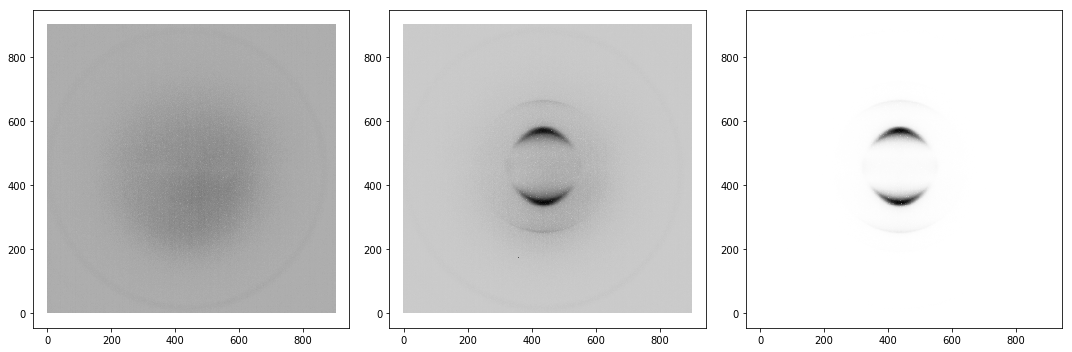

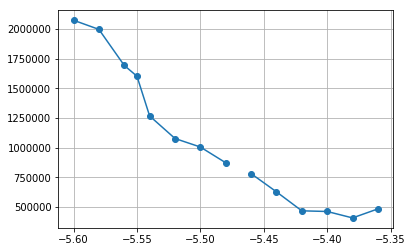

In [14]:
avg = {
    k: {'bg_n': summed.loc[(k, True), 'count'],
        'bg_img': summed.loc[(k, True), 'summed'] / summed.loc[(k, True), 'count'],
        'sg_n': summed.loc[(k, False), 'count'],
        'sg_img': summed.loc[(k, False), 'summed'] / summed.loc[(k, False), 'count'],
        'df_n': summed.loc[(k, False), 'count'],
        'df_img': (summed.loc[(k, False), 'summed'] / summed.loc[(k, False), 'count']
                   - summed.loc[(k, True), 'summed'] / summed.loc[(k, True), 'count'])}
    for k in df["delay"].unique()
} 

for k, d in avg.items():
    if k == 0:
        continue
    plt.figure(figsize=(15, 5))
    plt.subplot(131)
    plt.pcolormesh(d['bg_img'], cmap="Greys")
    plt.clim(0, None)
    plt.axis('equal')
    plt.subplot(132)
    plt.pcolormesh(d['sg_img'], cmap="Greys")
    plt.clim(0, None)
    plt.axis('equal')
    plt.subplot(133)
    plt.pcolormesh(d['df_img'], cmap="Greys")
    plt.clim(0, None)
    plt.axis('equal')
    plt.tight_layout()
    plt.show()
    break

plt.figure()
plt.plot([k for k in avg], [d['df_img'].sum() for d in avg.values()], 'o-')
plt.grid(True)
plt.show()

In [12]:
for k, d in avg.items():
    if k == 0:
        continue
    with File(f"{writein}/reduced_dt={k}.h5", "w") as f:
        f['bg_n'] = d['bg_n']
        f['bg_img'] = d['bg_img']
        f['sg_n'] = d['sg_n']
        f['sg_img'] = d['sg_img']
        f['df_n'] = d['df_n']
        f['df_img'] = d['df_img']